# MultiLayer Perceptron

MultiLayer Perceptron (MLP) is a popular neural network algorithm used for classification problems. MLPs consist of multiple layers of interconnected nodes, where each node in a layer is connected to all the nodes in the previous layer. MLPs can handle complex non-linear relationships between features and the target variable, making them a popular choice for classification tasks.

In this notebook, we will explore how to use MLP for classification problems using PySpark. Specifically, we will use the famous Iris dataset, which contains information about the physical characteristics of three different types of iris flowers, to build an MLP model that can predict the type of iris flower based on its features. We will cover the following topics:

Loading and preparing the data
Training an MLP model using PySpark's MLlib library
Evaluating the model's performance using various metrics
Tuning the model's hyperparameters to improve its performance
By the end of this notebook, you should have a good understanding of how MLP works and how to apply it to real-world classification problems using PySpark.

## Introduction

The Wine dataset is a classic machine learning dataset that contains the results of a chemical analysis of wines grown in a specific area of Italy. The dataset consists of 178 samples, each representing a different wine. The chemical analysis determined the quantities of 13 constituents found in each of the three types of wines: "Class 0" (59 samples), "Class 1" (71 samples), and "Class 2" (48 samples). The attributes of the wine include things like alcohol content, malic acid, ash, and color intensity. This dataset is commonly used for classification problems and has been extensively studied in the machine learning literature.

### Importing necessery libraries and download the dataset

In this section, we will import the required libraries and download the Wine dataset.

#### Importing Libraries
We will begin by importing the necessary libraries required for our analysis. These include:

- SparkSession: used for start and mantain a spark session
- RFormula: used for transform the dataset in something meaninful to spark
- StandardScaler: used for scaler the dataset
- GBT: used for construct the model
- Pipeline: used for create a pipeline
- skelearn: only used here to easy create a confusion matrix
- ParamGridBuilder: used for tuning the hyperparams of the model
- TrainValidationSplit: used for crossvalidation and select best hyperparams
- matplotlib: used for data visualization

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn import metrics
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.sql.functions import when

#### Downloading the Wine dataset
Next, we will download the Wine dataset using the curl command. The dataset is available in a CSV format.

Each column represents the following information:

1. alcohol: the percentage of alcohol content in the wine
2. malic_acid: the amount of malic acid in the wine
3. ash: the amount of ash in the wine
4. alcalinity_of_ash: the level of alkalinity of ash in the wine
5. magnesium: the amount of magnesium in the wine
6. total_phenols: the total amount of phenols in the wine
7. flavanoids: the amount of flavonoids in the wine
8. nonflavanoid_phenols: the total amount of non-flavonoid phenols in the wine
9. proanthocyanins: the amount of proanthocyanins in the wine
10. color_intensity: the intensity of color in the wine
11. hue: the hue of the wine
12. od280/od315_of_diluted_wines: the OD280/OD315 ratio of the diluted wines
13. proline: the amount of proline in the wine

The target variable is the class column, which represents the class of the wine. There are three classes of wine in this dataset:

- class_0: Wine produced in the region of Barolo in Italy
- class_1: Wine produced in the region of Grignolino d'Asti in Italy
- class_2: Wine produced in the region of Barbera in Italy

In [ ]:
! curl https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data -o wine.csv

In [2]:
schema = 'class INT, alcohol FLOAT, malic_acid FLOAT, ash FLOAT, alcalinity FLOAT, magnesium FLOAT, total_phenols FLOAT, flavanoids FLOAT, nonflavanoid_phenols FLOAT, proanthocyanins FLOAT, color_intensity FLOAT, hue FLOAT, od FLOAT, proline FLOAT'
# init SparkSession
spark = SparkSession.builder.appName('MLPClassifier').getOrCreate()
# read the csv using pyspark
wine = spark.read.csv('./wine.csv', schema=schema, header=False)

# print few lines of the dataframe
wine.show(5)

+-----+-------+----------+----+----------+---------+-------------+----------+--------------------+---------------+---------------+----+----+-------+
|class|alcohol|malic_acid| ash|alcalinity|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity| hue|  od|proline|
+-----+-------+----------+----+----------+---------+-------------+----------+--------------------+---------------+---------------+----+----+-------+
|    1|  14.23|      1.71|2.43|      15.6|    127.0|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|3.92| 1065.0|
|    1|   13.2|      1.78|2.14|      11.2|    100.0|         2.65|      2.76|                0.26|           1.28|           4.38|1.05| 3.4| 1050.0|
|    1|  13.16|      2.36|2.67|      18.6|    101.0|          2.8|      3.24|                 0.3|           2.81|           5.68|1.03|3.17| 1185.0|
|    1|  14.37|      1.95| 2.5|      16.8|    113.0|         3.85|      3.49|                0.24|        

## Exploratory Data Analysis

### Summary statistics of the dataset

In this section, we will explore the iris datasets giving some statistic description like mean, std, etc.

In [3]:
from pyspark.sql.functions import round
temp = wine.drop('class')
temp.describe().select(['summary'] + [round(c, 2).alias(c) for c in temp.columns]).show()

+-------+-------+----------+-----+----------+---------+-------------+----------+--------------------+---------------+---------------+-----+-----+-------+
|summary|alcohol|malic_acid|  ash|alcalinity|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity|  hue|   od|proline|
+-------+-------+----------+-----+----------+---------+-------------+----------+--------------------+---------------+---------------+-----+-----+-------+
|  count|  178.0|     178.0|178.0|     178.0|    178.0|        178.0|     178.0|               178.0|          178.0|          178.0|178.0|178.0|  178.0|
|   mean|   13.0|      2.34| 2.37|     19.49|    99.74|          2.3|      2.03|                0.36|           1.59|           5.06| 0.96| 2.61| 746.89|
| stddev|   0.81|      1.12| 0.27|      3.34|    14.28|         0.63|       1.0|                0.12|           0.57|           2.32| 0.23| 0.71| 314.91|
|    min|  11.03|      0.74| 1.36|      10.6|     70.0|         0.98|      0

In [4]:
n_features = len(temp.columns)
n_features

13

In [5]:
from pyspark.sql.functions import countDistinct
n_classes = wine.select(countDistinct('class')).collect()[0][0]
n_classes

3

In [6]:
wine.select('class').distinct().show()

+-----+
|class|
+-----+
|    1|
|    3|
|    2|
+-----+



In [7]:
# in order to use theses classes we need to map the class to 1->0, 2->1 and 3->2
from pyspark.sql.functions import col
wine = wine.withColumn("class_mapped", col('class') - 1)

### Preprocessing the data (e.g., scaling, normalization, encoding)

Here we will use the RFormula to separate and treat the dataframe and the MinMaxScaller

In [10]:
train, test = wine.randomSplit([0.8, 0.2])

In [11]:
# we need to remember to remove the class from features with - class 
temp = wine.drop('class', 'class_mapped')
assembler = VectorAssembler(inputCols=temp.columns, outputCol='features')
# only to see if everything is ok
assembler.transform(train).select('features', 'class_mapped').show(5)

+--------------------+------------+
|            features|class_mapped|
+--------------------+------------+
|[12.8500003814697...|           0|
|[12.9300003051757...|           0|
|[13.0500001907348...|           0|
|[13.0500001907348...|           0|
|[13.0500001907348...|           0|
+--------------------+------------+
only showing top 5 rows



In [13]:
temp = assembler.transform(train)
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', )
# only to see if everything is ok
scaler.fit(temp).transform(temp).select('features', 'scaledFeatures').show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[12.8500003814697...|[16.4588799412302...|
|[12.9300003051757...|[16.5613475755102...|
|[13.0500001907348...|[16.7150490269301...|
|[13.0500001907348...|[16.7150490269301...|
|[13.0500001907348...|[16.7150490269301...|
+--------------------+--------------------+
only showing top 5 rows



## Model Training
 Here we will build the model and create the pipeline that will be trained
 
### Building a MLP Classifier

In [15]:
layers = [n_features, 100, n_classes]
mlp = MultilayerPerceptronClassifier(labelCol="class_mapped", featuresCol="features", layers=layers)
pipeline = Pipeline(stages=[assembler, scaler, mlp])

### Training the model on the training set

In [16]:
model = pipeline.fit(train)

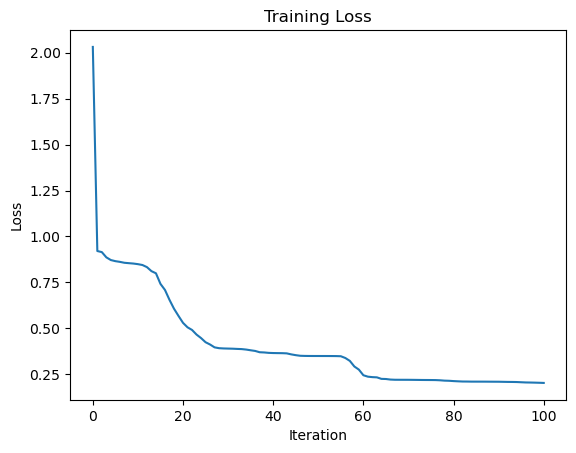

In [27]:
import matplotlib.pyplot as plt
# extract the loss history
loss_history = model.stages[-1].summary().objectiveHistory

# plot the loss history
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

### Evaluating the performance of the model

In [19]:
prd = model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol='class_mapped', metricName='accuracy')

# Area under precision-recall curve
print("Accuracy = %s" % evaluator.evaluate(prd, {evaluator.metricName: "accuracy"}))

# Area under ROC curve
print("F1 score = %s" % evaluator.evaluate(prd, {evaluator.metricName: "f1"}))

Accuracy = 0.918918918918919
F1 score = 0.9183878615457561


## Model Tuning and Interpretation

Fine-tuning the model (e.g., hyperparameter tuning)

In [28]:
param_grid = ParamGridBuilder() \
    .addGrid(mlp.layers, [[13, 20, 20, 3], [13, 50, 3], [13, 25, 10, 3]]) \
    .addGrid(mlp.blockSize, [64, 128]) \
    .addGrid(mlp.maxIter, [50, 100, 200]) \
    .addGrid(mlp.solver, ['l-bfgs', 'gd']) \
    .build()
pipeline = Pipeline(stages=[assembler, scaler, mlp])
tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.8)

In [29]:
model2 = tvs.fit(train)
prd2 = model2.transform(test)
prd2.select('prediction', 'class_mapped').show(5)

+----------+------------+
|prediction|class_mapped|
+----------+------------+
|       0.0|           0|
|       2.0|           0|
|       0.0|           0|
|       0.0|           0|
|       0.0|           0|
+----------+------------+
only showing top 5 rows



In [35]:
# get the best model
bestModel = model2.bestModel

# get the best hyperparameters
bestParams = bestModel.stages[-1].extractParamMap()
bestParams

{Param(parent='MultilayerPerceptronClassifier_c3c8cf7290e3', name='blockSize', doc='block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data.'): 64,
 Param(parent='MultilayerPerceptronClassifier_c3c8cf7290e3', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='MultilayerPerceptronClassifier_c3c8cf7290e3', name='labelCol', doc='label column name.'): 'class_mapped',
 Param(parent='MultilayerPerceptronClassifier_c3c8cf7290e3', name='maxIter', doc='max number of iterations (>= 0).'): 200,
 Param(parent='MultilayerPerceptronClassifier_c3c8cf7290e3', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='MultilayerPerceptronClassifier_c3c8cf7290e3', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probab

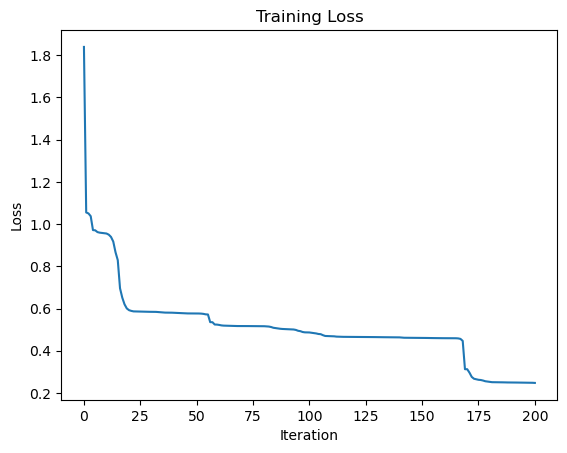

In [36]:
# extract the loss history
loss_history = bestModel.stages[-1].summary().objectiveHistory

# plot the loss history
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [37]:
prd = model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol='class_mapped', metricName='accuracy')

# Area under precision-recall curve
print("Accuracy = %s" % evaluator.evaluate(prd, {evaluator.metricName: "accuracy"}))

# Area under ROC curve
print("F1 score = %s" % evaluator.evaluate(prd, {evaluator.metricName: "f1"}))

Accuracy = 0.918918918918919
F1 score = 0.9183878615457561


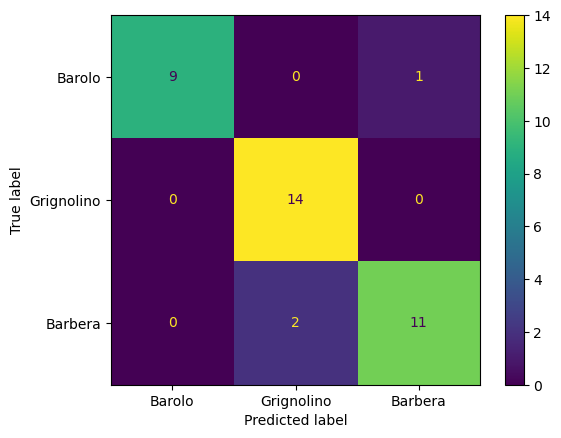

In [40]:
from sklearn import metrics
# - class_0: Wine produced in the region of Barolo in Italy
# - class_1: Wine produced in the region of Grignolino d'Asti in Italy
# - class_2: Wine produced in the region of Barbera in Italy 
df_prd = prd.select('class_mapped', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd['class_mapped'], df_prd['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Barolo', 'Grignolino', 'Barbera'])
cm_display.plot()
plt.show()

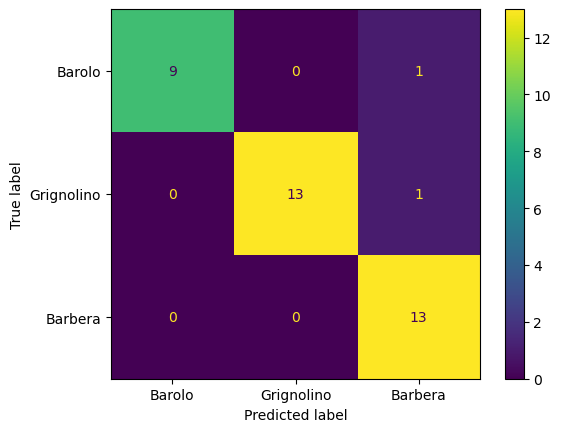

In [41]:
df_prd2 = prd2.select('class_mapped', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd2['class_mapped'], df_prd2['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Barolo', 'Grignolino', 'Barbera'])
cm_display.plot()
plt.show()

In [42]:
spark.stop()